In [ ]:
import os
import re
import argparse
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from urllib.parse import urlparse
from scipy.stats import entropy
from scipy.sparse import hstack

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, roc_auc_score, accuracy_score,
    confusion_matrix, precision_score, recall_score, make_scorer
)
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import joblib
import tldextract

warnings.filterwarnings("ignore")

In [ ]:
print("=== LOADING DATA ===")
PATH = "data/combined_dataset_simple.csv"  
df = pd.read_csv(PATH)

=== LOADING DATA ===
Dataset shape: (1537618, 2)
Class distribution:
label
legitimate    1345728
phishing       191890
Name: count, dtype: int64


In [3]:
df.describe()

,url,label,type
count,1537618,1537618,1537618
unique,1537618,2,2
top,https://www.wiki.answers.com/Q/What_are_the_te...,legitimate,legitimate
freq,1,1345728,1345728


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1537618 entries, 0 to 1537617
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   url     1537618 non-null  object
 1   label   1537618 non-null  object
 2   type    1537618 non-null  object
dtypes: object(3)
memory usage: 35.2+ MB


In [5]:
df.head(10)

,url,label,type
0,https://www.wiki.answers.com/Q/What_are_the_te...,legitimate,legitimate
1,https://www.myshopping.com.au/ZM--1144685847_B...,legitimate,legitimate
2,https://track-delivery.click/procced,phishing,phishing
3,https://www.montrealchinesehospital.ca/en/foun...,legitimate,legitimate
4,http://paynbuy.net/sign_in_survey/loading.php?...,phishing,phishing
5,https://www.content.usatoday.com/community/tag...,legitimate,legitimate
6,https://docs.google.com/presentation/d/1TPib0R...,phishing,phishing
7,https://www.weei.com/sports/boston/this-just-i...,legitimate,legitimate
8,https://www.123people.ca/s/benoit+tousignant,legitimate,legitimate
9,https://www.westcat.org/schedules/routeJsatsb....,legitimate,legitimate


<h2 style="text-align:center; color:green;">Feature Extractions</h2>

In [ ]:
def extract_features(df):
    df = df.copy()
    
    # clean URLs
    df['url'] = df['url'].str.replace(r'\.', '.', regex=True)
    df['full_url_for_parsing'] = df['url'].apply(
        lambda x: 'http://' + x if isinstance(x, str) and not x.startswith(('http://', 'https://')) else x
    )

    def safe_parse_hostname(url):
        try:
            return urlparse(url).netloc
        except:
            if isinstance(url, str):
                url_clean = re.sub(r'^https?://', '', url)
                return url_clean.split('/')[0]
            return ''

    df['hostname'] = df['full_url_for_parsing'].apply(safe_parse_hostname)
    if 'domain' not in df.columns:
        df['domain'] = df['hostname']

    # ========== FAST LEXICAL FEATURES ==========
    df['url_length'] = df['url'].apply(len)
    df['hostname_length'] = df['hostname'].apply(len)
    df['dot_count'] = df['url'].str.count(r'\.')
    df['hyphen_count'] = df['url'].str.count('-')
    df['at_symbol_count'] = df['url'].str.count('@')
    df['path_depth'] = df['url'].str.count('/')
    df['digit_count'] = df['url'].str.count(r'[0-9]')
    df['digit_ratio'] = df['digit_count'] / df['url_length'].replace(0, 1)
    df['has_ip_address'] = df['hostname'].str.match(r'^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$').astype(int)

    # security indicators
    df['subdomain_count'] = df['hostname'].apply(lambda x: len(x.split('.')) - 2 if x else 0).clip(lower=0)
    df['has_port'] = df['hostname'].str.contains(r':\d+', regex=True, na=False).astype(int)

    # character analysis
    df['special_char_count'] = df['url'].apply(
        lambda x: sum(not c.isalnum() for c in x) if isinstance(x, str) else 0
    )
    df['special_char_ratio'] = df['special_char_count'] / df['url_length'].replace(0, 1)
    df['uppercase_ratio'] = df['url'].apply(
        lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0
    )

    # entropy
    df['hostname_entropy'] = df['hostname'].apply(
        lambda x: entropy(np.unique(list(x), return_counts=True)[1]) if x else 0
    )
    df['path_entropy'] = df['url'].apply(
        lambda x: entropy(np.unique(list(x.split('/')[-1]), return_counts=True)[1]) 
        if '/' in x and x.split('/')[-1] else 0
    )

    # additional features
    df['has_shortener'] = df['hostname'].str.contains(
        r'(bit\.ly|tinyurl|t\.co|goo\.gl)', regex=True, na=False
    ).astype(int)
    df['consecutive_dots'] = df['url'].str.count(r'\.{2,}')

    return df


def extract_advanced_phishing_features(df):
    df = df.copy()
    # 1. GRANDPARENT DOMAIN MISMATCH FEATURE

    def detect_impersonation_domain(url):
   
        try:
            ext = tldextract.extract(url)
            main_domain = f"{ext.domain}.{ext.suffix}"
            subdomain = ext.subdomain
            
            if not subdomain:
                return 0
     
            subdomain_ext = tldextract.extract(subdomain)
            
            if subdomain_ext.domain and subdomain_ext.suffix:
                grandparent_domain = f"{subdomain_ext.domain}.{subdomain_ext.suffix}"
                if grandparent_domain != main_domain and grandparent_domain != subdomain:
                    return 1

            common_tlds = ['com', 'net', 'org', 'de', 'co.uk', 'fr', 'it', 'es', 'jp', 'cn', 'in', 'br', 'ru']
            for tld in common_tlds:
                pattern = r'([a-zA-Z0-9-]+)\.' + tld.replace('.', r'\.')
                matches = re.findall(pattern, subdomain)
                for match in matches:
                    potential_domain = f"{match}.{tld}"
                    if potential_domain != main_domain:
                        return 1
                        
            return 0
        except:
            return 0
    
    # 2. SUBDOMAIN ANOMALY SCORE
    def calculate_subdomain_suspicion_score(url):
        try:
            ext = tldextract.extract(url)
            subdomain = ext.subdomain.lower()
            
            if not subdomain:
                return 0
            
            score = 0
            sensitive_keywords = [
                'login', 'secure', 'account', 'verify', 'update', 'confirm',
                'banking', 'payment', 'paypal', 'amazon', 'google', 'microsoft',
                'apple', 'support', 'service', 'customer', 'alert', 'suspended',
                'locked', 'expired', 'refund', 'invoice', 'billing'
            ]
            
            for keyword in sensitive_keywords:
                if keyword in subdomain:
                    score += 1
            
            if subdomain.count('-') > 1:
                score += 1
            
            if len(subdomain) > 20:
                score += 1
            
            if re.search(r'\d{3,}', subdomain):
                score += 1
            
            if '.' in subdomain:
                score += 1
                
            return score
        except:
            return 0
    
    # 3. DOMAIN HYPHEN FEATURE
    def domain_contains_hyphen(url):
        try:
            ext = tldextract.extract(url)
            domain = ext.domain
            return 1 if '-' in domain else 0
        except:
            return 0
    
    def get_subdomain_depth(url):
        try:
            ext = tldextract.extract(url)
            return len(ext.subdomain.split('.')) if ext.subdomain else 0
        except:
            return 0
    
    print("Extracting advanced phishing features...")
    df['has_impersonation_domain'] = df['url'].apply(detect_impersonation_domain)
    df['subdomain_suspicion_score'] = df['url'].apply(calculate_subdomain_suspicion_score)
    df['domain_contains_hyphen'] = df['url'].apply(domain_contains_hyphen)
    df['subdomain_depth'] = df['url'].apply(get_subdomain_depth)
    
    return df


print("=== LOADING DATA ===")
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['label'].value_counts()}")

original_size = len(df)
df = df.drop_duplicates(subset=['url']).reset_index(drop=True)
print(f"After deduplication: {len(df)} samples (removed {original_size - len(df)})")

print("\n=== FAST FEATURE EXTRACTION ===")
df = extract_features(df)

df = extract_advanced_phishing_features(df)

# all features including the new ones
advanced_features = [
    'has_impersonation_domain',
    'subdomain_suspicion_score', 
    'domain_contains_hyphen',
    'subdomain_depth'
]

fast_lexical_features = [
    'url_length', 'hostname_length', 'dot_count', 'hyphen_count',
    'at_symbol_count', 'path_depth', 'digit_ratio', 'has_ip_address', 
    'subdomain_count', 'has_port', 'special_char_ratio', 'uppercase_ratio', 
    'hostname_entropy', 'path_entropy', 'has_shortener', 'consecutive_dots'
] + advanced_features

missing_features = [f for f in fast_lexical_features if f not in df.columns]
if missing_features:
    print(f"Warning: Missing features: {missing_features}")
    
df[fast_lexical_features] = df[fast_lexical_features].fillna(0)
print(f"Using {len(fast_lexical_features)} features (including {len(advanced_features)} advanced features)")

print("\n=== ADVANCED FEATURE EXAMPLES ===")
phishing_examples = df[df['label'] == 'phishing'].head(10)
print(phishing_examples[['url', 'has_impersonation_domain', 'subdomain_suspicion_score', 'domain_contains_hyphen']])


=== LOADING DATA ===
Dataset shape: (1537618, 3)
Class distribution:
label
legitimate    1345728
phishing       191890
Name: count, dtype: int64
After deduplication: 1537618 samples (removed 0)

=== FAST FEATURE EXTRACTION ===
Extracting advanced phishing features...
Using 20 features (including 4 advanced features)

=== ADVANCED FEATURE EXAMPLES ===
                                                  url  \
2                https://track-delivery.click/procced   
4   http://paynbuy.net/sign_in_survey/loading.php?...   
6   https://docs.google.com/presentation/d/1TPib0R...   
11                 http://222.239.91.18:127/xiaomo123   
13  https://tye67d8uigtyc768iojhgtywe67898d7yujh.p...   
19                       http://nevinka.ws/09y7gnninj   
20  http://www.logonto.me/cig/update.your.informat...   
25     http://www.localpastures.com.au/media/jkh.html   
26                             http://httpsstarss.in/   
27                 http://aishhyplwa.com/loading.html   

    has_impersonati

In [7]:
df.describe().astype(int)

,url_length,hostname_length,dot_count,hyphen_count,at_symbol_count,path_depth,digit_count,digit_ratio,has_ip_address,subdomain_count,...,special_char_ratio,uppercase_ratio,hostname_entropy,path_entropy,has_shortener,consecutive_dots,has_impersonation_domain,subdomain_suspicion_score,domain_contains_hyphen,subdomain_depth
count,1537618,1537618,1537618,1537618,1537618,1537618,1537618,1537618,1537618,1537618,...,1537618,1537618,1537618,1537618,1537618,1537618,1537618,1537618,1537618,1537618
mean,31,16,1,0,0,1,1,0,0,0,...,0,0,2,0,0,0,0,0,0,0
std,45,6,1,1,0,2,8,0,0,0,...,0,0,0,1,0,0,0,0,0,0
min,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25%,13,12,1,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
50%,18,15,1,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
75%,40,20,2,0,0,3,0,0,0,1,...,0,0,2,0,0,0,0,0,0,1
max,25523,246,32,63,43,104,3413,0,1,20,...,0,0,3,4,1,7,1,9,1,20


In [8]:
df.head(50)

,url,label,type,full_url_for_parsing,hostname,domain,url_length,hostname_length,dot_count,hyphen_count,...,special_char_ratio,uppercase_ratio,hostname_entropy,path_entropy,has_shortener,consecutive_dots,has_impersonation_domain,subdomain_suspicion_score,domain_contains_hyphen,subdomain_depth
0,https://www.wiki.answers.com/Q/What_are_the_te...,legitimate,legitimate,https://www.wiki.answers.com/Q/What_are_the_te...,www.wiki.answers.com,www.wiki.answers.com,74,20,3,0,...,0.202703,0.040541,2.289952,2.674314,0,0,0,1,0,2
1,https://www.myshopping.com.au/ZM--1144685847_B...,legitimate,legitimate,https://www.myshopping.com.au/ZM--1144685847_B...,www.myshopping.com.au,www.myshopping.com.au,50,21,3,2,...,0.200000,0.060000,2.532591,2.553682,0,0,0,0,0,1
2,https://track-delivery.click/procced,phishing,phishing,https://track-delivery.click/procced,track-delivery.click,track-delivery.click,36,20,1,1,...,0.166667,0.000000,2.484367,1.747868,0,0,0,0,1,0
3,https://www.montrealchinesehospital.ca/en/foun...,legitimate,legitimate,https://www.montrealchinesehospital.ca/en/foun...,www.montrealchinesehospital.ca,www.montrealchinesehospital.ca,60,30,3,0,...,0.150000,0.000000,2.655725,2.553237,0,0,0,0,0,1
4,http://paynbuy.net/sign_in_survey/loading.php?...,phishing,phishing,http://paynbuy.net/sign_in_survey/loading.php?...,paynbuy.net,paynbuy.net,79,11,7,0,...,0.227848,0.000000,2.145842,2.855134,0,1,0,0,0,0
5,https://www.content.usatoday.com/community/tag...,legitimate,legitimate,https://www.content.usatoday.com/community/tag...,www.content.usatoday.com,www.content.usatoday.com,96,24,4,0,...,0.166667,0.031250,2.455461,3.133008,0,0,0,1,0,2
6,https://docs.google.com/presentation/d/1TPib0R...,phishing,phishing,https://docs.google.com/presentation/d/1TPib0R...,docs.google.com,docs.google.com,131,15,2,1,...,0.152672,0.122137,2.061113,2.839490,0,0,0,0,0,1
7,https://www.weei.com/sports/boston/this-just-i...,legitimate,legitimate,https://www.weei.com/sports/boston/this-just-i...,www.weei.com,www.weei.com,88,12,2,6,...,0.181818,0.000000,1.791759,2.531453,0,0,0,0,0,1
8,https://www.123people.ca/s/benoit+tousignant,legitimate,legitimate,https://www.123people.ca/s/benoit+tousignant,www.123people.ca,www.123people.ca,44,16,2,0,...,0.181818,0.000000,2.306669,2.282374,0,0,0,0,0,1
9,https://www.westcat.org/schedules/routeJsatsb....,legitimate,legitimate,https://www.westcat.org/schedules/routeJsatsb....,www.westcat.org,www.westcat.org,50,15,3,0,...,0.160000,0.020000,2.153532,2.479956,0,0,0,0,0,1



<h2 style="text-align:center; color:orange;">STRATIFIED TRAIN-TEST SPLIT</h2>

In [9]:
print("\n=== STRATIFIED TRAIN-TEST SPLITTING ===")

X = df.drop(['type', 'label'], axis=1)
y = df['type']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)} ({(y_train == 'phishing').sum()} phishing)")
print(f"Testing samples: {len(X_test)} ({(y_test == 'phishing').sum()} phishing)")

print("\n=== APPLYING SMOTE OVERSAMPLING ===")
train_urls = X_train['url'].copy()
test_urls = X_test['url'].copy()

X_train_numeric = X_train[fast_lexical_features].copy()
X_test_numeric = X_test[fast_lexical_features].copy()
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=5)
X_train_balanced_numeric, y_train_balanced = smote.fit_resample(X_train_numeric, y_train)
X_train_balanced = pd.DataFrame(X_train_balanced_numeric, columns=fast_lexical_features)

minority_urls = train_urls[y_train == 'phishing'].values
n_synthetic = len(X_train_balanced) - len(X_train)
synthetic_urls = np.random.choice(minority_urls, size=n_synthetic, replace=True)

balanced_urls = np.concatenate([train_urls.values, synthetic_urls])
X_train_balanced['url'] = balanced_urls

print(f"Balanced training set: {len(X_train_balanced)} samples")
print(f"Class distribution after SMOTE:\n{pd.Series(y_train_balanced).value_counts()}")


=== STRATIFIED TRAIN-TEST SPLITTING ===
Training samples: 1230094 (153512 phishing)
Testing samples: 307524 (38378 phishing)

=== APPLYING SMOTE OVERSAMPLING ===
Balanced training set: 2153164 samples
Class distribution after SMOTE:
type
legitimate    1076582
phishing      1076582
Name: count, dtype: int64


<h2 style="text-align:center; color:pink;">Train Standard Model</h2>

In [ ]:
print("\n=== LIGHTGBM MODEL TRAINING WITH GRID SEARCH ===")

# TF-IDF Vectorizers
tfidf_char = TfidfVectorizer(
    analyzer='char', ngram_range=(3, 5), max_features=1000, 
    min_df=5, max_df=0.6
)
tfidf_word = TfidfVectorizer(
    analyzer='word', token_pattern=r'(?u)\b\w\w+\b', 
    ngram_range=(1, 2), max_features=500, min_df=5, max_df=0.6
)

# feature scaling
scaler = StandardScaler()

X_train_tfidf_char = tfidf_char.fit_transform(X_train_balanced['url'])
X_train_tfidf_word = tfidf_word.fit_transform(X_train_balanced['url'])
X_train_lexical = scaler.fit_transform(X_train_balanced[fast_lexical_features])
X_train_combined = hstack([X_train_lexical, X_train_tfidf_char, X_train_tfidf_word]).tocsr()

X_test_tfidf_char = tfidf_char.transform(X_test['url'])
X_test_tfidf_word = tfidf_word.transform(X_test['url'])
X_test_lexical = scaler.transform(X_test[fast_lexical_features])
X_test_combined = hstack([X_test_lexical, X_test_tfidf_char, X_test_tfidf_word]).tocsr()

print(f"Combined feature matrix shape: {X_train_combined.shape}")
print(f"Features: {len(fast_lexical_features)} lexical + {X_train_tfidf_char.shape[1]} char n-grams + {X_train_tfidf_word.shape[1]} word n-grams")

# convert target labels to binary for LightGBM
y_train_binary = (y_train_balanced == 'phishing').astype(int)
y_test_binary = (y_test == 'phishing').astype(int)

# params
param_grid = {
    'n_estimators': [300],
    'max_depth': [15],
    'learning_rate': [0.01],
    'num_leaves': [100],
    'min_child_samples': [50],
    'subsample': [1.0],
    'colsample_bytree': [1.0]
}

# LightGBM classifier
lgb_model = LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    boosting_type='gbdt',
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# GridSearchCV
print("Starting GridSearchCV...")
f1_scorer = make_scorer(f1_score)
grid_search = GridSearchCV(
    lgb_model,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring=f1_scorer,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
grid_search.fit(X_train_combined, y_train_binary)

# Get best model
best_lgb_model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# create the raw list of feature names 
raw_feature_names = fast_lexical_features + tfidf_char.get_feature_names_out().tolist() + tfidf_word.get_feature_names_out().tolist()

# sanitize feature names for LightGBM
def sanitize_feature_name(name):
    """Remove all special characters that could cause JSON issues"""
    # Convert to string first
    name = str(name)
    # Replace all non-alphanumeric characters (except underscore) with underscore
    name = re.sub(r'[^a-zA-Z0-9_]', '_', name)
    # Remove consecutive underscores
    name = re.sub(r'_+', '_', name)
    # Remove leading/trailing underscores
    name = name.strip('_')
    # If name is empty after sanitization, give it a default name
    if not name:
        name = 'feature'
    return name

feature_names = [sanitize_feature_name(name) for name in raw_feature_names]

# Ensure unique feature names (in case sanitization creates duplicates)
seen = set()
unique_feature_names = []
for i, name in enumerate(feature_names):
    original_name = name
    counter = 1
    while name in seen:
        name = f"{original_name}_{counter}"
        counter += 1
    seen.add(name)
    unique_feature_names.append(name)

feature_names = unique_feature_names

print("\nTraining best LightGBM model...")
best_lgb_model.fit(X_train_combined, y_train_binary, feature_name=feature_names)

print("Applying calibration...")
calibrated_model = CalibratedClassifierCV(best_lgb_model, method='isotonic', cv=5)
calibrated_model.fit(X_train_combined, y_train_binary)

y_prob = calibrated_model.predict_proba(X_test_combined)[:, 1]

print("Optimizing threshold...")
thresholds = np.linspace(0, 1, 100)
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_test_binary, y_pred_threshold)
    f1_scores.append(f1)

optimal_threshold = min(thresholds[np.argmax(f1_scores)] + 0.1, 1.0)
print(f"Optimal threshold: {optimal_threshold:.3f}")
y_pred_binary = (y_prob >= optimal_threshold).astype(int)
y_pred = np.where(y_pred_binary == 1, 'phishing', 'legitimate')


In [ ]:
print("\n=== MODEL EVALUATION ===")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='phishing')
recall = recall_score(y_test, y_pred, pos_label='phishing')
f1 = f1_score(y_test, y_pred, pos_label='phishing')
auc = roc_auc_score(y_test_binary, y_prob)

print(f"\nFinal Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

print("\n=== FEATURE IMPORTANCE ANALYSIS ===")
feature_names = fast_lexical_features + list(tfidf_char.get_feature_names_out()) + list(tfidf_word.get_feature_names_out())
importances = best_lgb_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Show importance of advanced features
advanced_importance = importance_df[importance_df['feature'].isin(advanced_features)]
print("\nAdvanced Feature Importance:")
print(advanced_importance.to_string(index=False))

lexical_importance = importance_df[importance_df['feature'].isin(fast_lexical_features)]
print("\nTop 15 Lexical Features:")
print(lexical_importance.head(15).to_string(index=False))

# Show top 20 overall features
print("\nTop 20 Overall Features:")
print(importance_df.head(20).to_string(index=False))

print("\n=== CROSS-VALIDATION ANALYSIS ===")
f1_scorer = make_scorer(f1_score)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(
    best_lgb_model, X_train_combined, y_train_binary, 
    cv=cv, scoring=f1_scorer, n_jobs=-1
)

print(f"CV F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix - LightGBM with Advanced Features')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

def predict_urls_fast(urls):
  
    new_df = pd.DataFrame({'url': urls})
    # extract basic features
    new_df = extract_features(new_df)
    
    # extract advanced phishing features
    new_df = extract_advanced_phishing_features(new_df)
    new_df[fast_lexical_features] = new_df[fast_lexical_features].fillna(0)
    
    # transform features
    new_tfidf_char = tfidf_char.transform(new_df['url'])
    new_tfidf_word = tfidf_word.transform(new_df['url'])
    new_lexical = scaler.transform(new_df[fast_lexical_features])
    new_combined = hstack([new_lexical, new_tfidf_char, new_tfidf_word]).tocsr()
    
    probabilities = calibrated_model.predict_proba(new_combined)[:, 1]
    
    results_df = pd.DataFrame({
        'URL': urls,
        'Prediction': np.where(probabilities >= optimal_threshold, 'PHISHING', 'LEGITIMATE'),
        'Probability': probabilities,
        'Confidence': np.abs(probabilities - 0.5) * 2
    })
    
    # Add the advanced feature values for inspection
    feature_details = new_df[['has_impersonation_domain', 'subdomain_suspicion_score', 'domain_contains_hyphen']]
    return pd.concat([results_df, feature_details], axis=1)

print("\n=== SAVING LIGHTGBM MODEL ===")

model_artifacts = {
    'model': calibrated_model,
    'base_model': best_lgb_model,
    'best_params': grid_search.best_params_,
    'tfidf_char': tfidf_char,
    'tfidf_word': tfidf_word,
    'scaler': scaler,
    'features': fast_lexical_features,
    'threshold': optimal_threshold,
    'performance': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc,
        'cv_f1_mean': cv_scores.mean(),
        'cv_f1_std': cv_scores.std()
    }
}

joblib.dump(model_artifacts, 'data/lightgbm_advanced_model.pkl')
print("LightGBM Advanced Model saved!")

# save test results with advanced features
test_results = pd.DataFrame({
    'url': df.loc[X_test.index, 'url'],
    'true_label': y_test,
    'prediction': y_pred,
    'probability': y_prob,
    'confidence': np.abs(y_prob - 0.5) * 2,
    'has_impersonation_domain': df.loc[X_test.index, 'has_impersonation_domain'],
    'subdomain_suspicion_score': df.loc[X_test.index, 'subdomain_suspicion_score'],
    'domain_contains_hyphen': df.loc[X_test.index, 'domain_contains_hyphen']
})

test_results.to_csv('data/lightgbm_advanced_results.csv', index=False)
print("Test results saved!")



Extracting advanced phishing features...


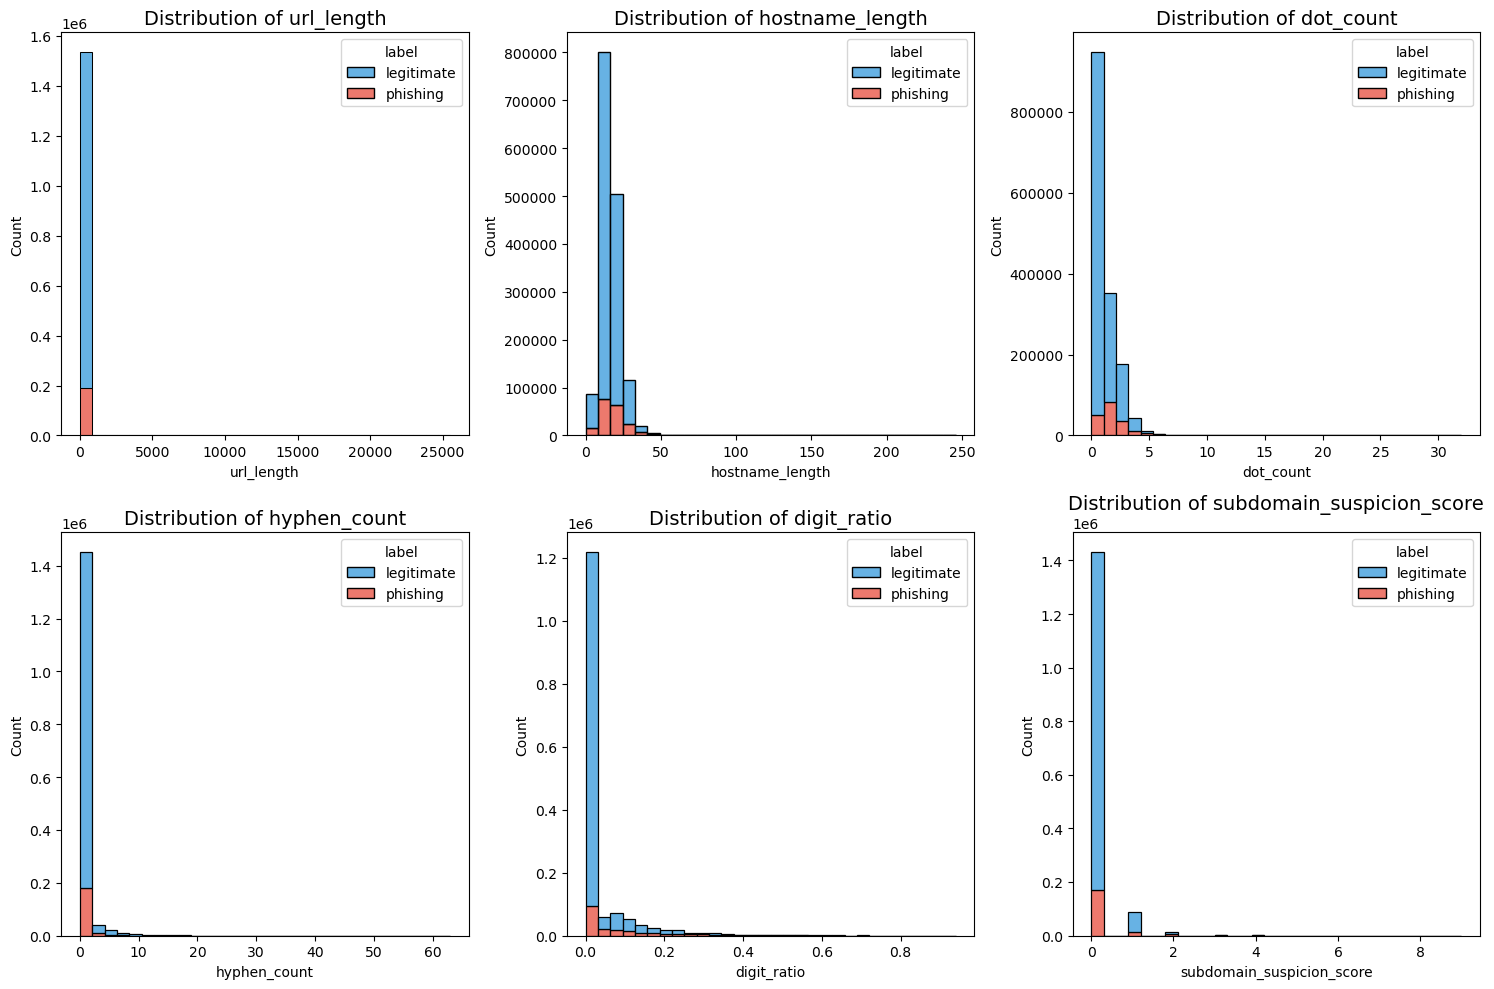

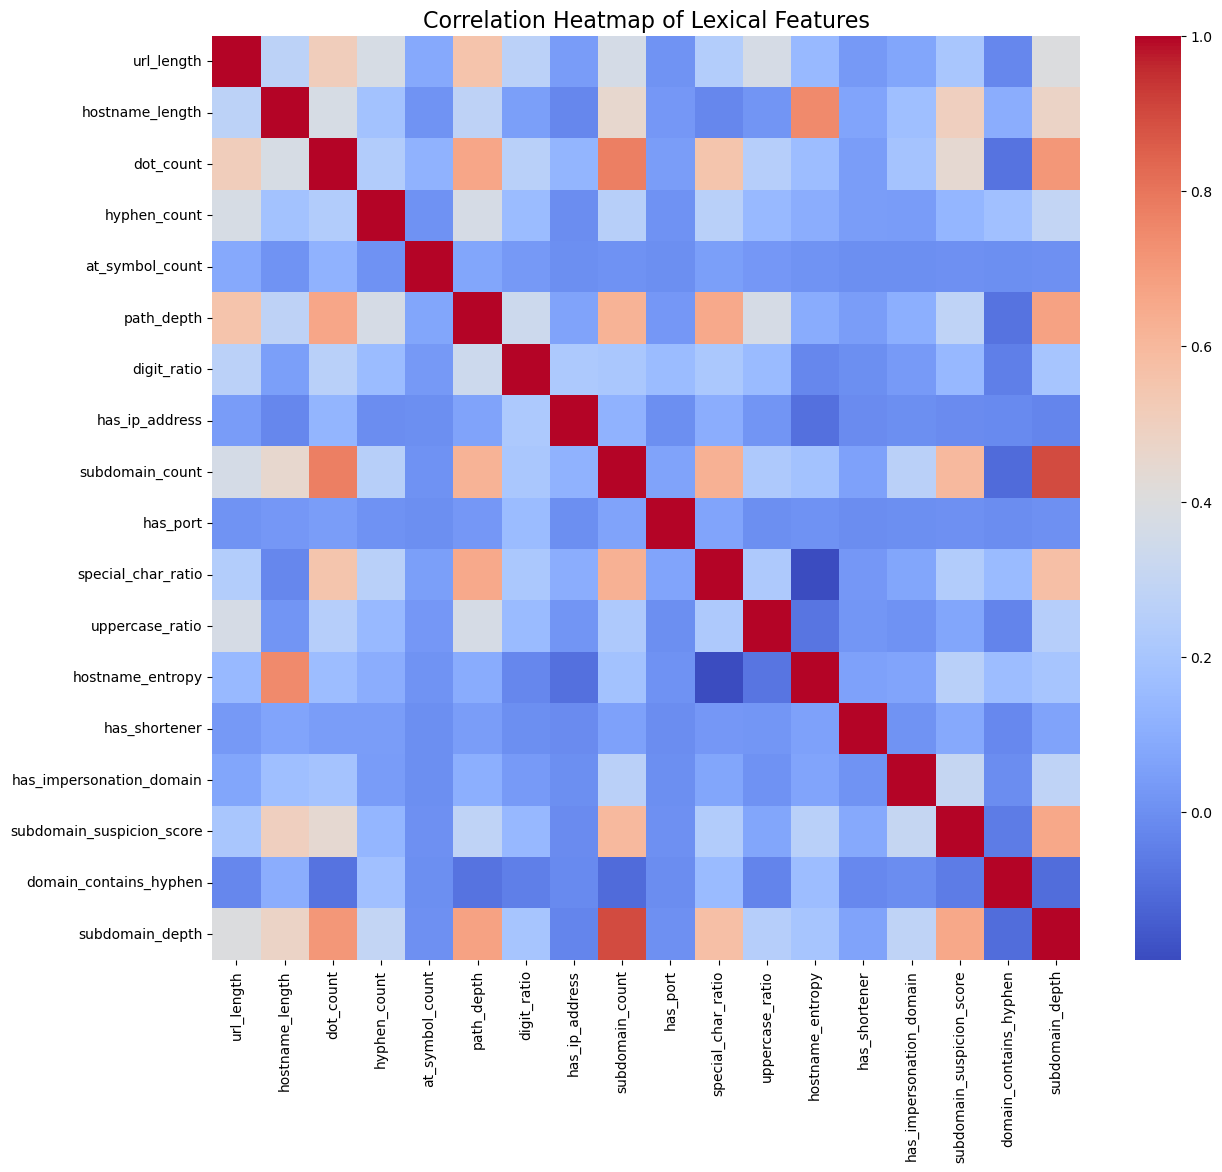

In [ ]:
df_features = extract_features(df.copy())
df_features = extract_advanced_phishing_features(df_features)

# === EDA: Visualize Feature Distributions ===
features_to_plot = ['url_length', 'hostname_length', 'dot_count', 'hyphen_count', 'digit_ratio', 'subdomain_suspicion_score']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df_features, x=feature, hue='label', palette=['#3498db', '#e74c3c'], multiple='stack', bins=30)
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 12))
lexical_features = [
    'url_length', 'hostname_length', 'dot_count', 'hyphen_count',
    'at_symbol_count', 'path_depth', 'digit_ratio', 'has_ip_address',
    'subdomain_count', 'has_port', 'special_char_ratio', 'uppercase_ratio',
    'hostname_entropy', 'has_shortener', 'has_impersonation_domain',
    'subdomain_suspicion_score', 'domain_contains_hyphen', 'subdomain_depth'
]
correlation_matrix = df_features[lexical_features].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap of Lexical Features', fontsize=16)
plt.show()


In [16]:
"""
+--------------------------------------------------------------------------------------------------+
|                                           Input: Raw URL                                         |
|                                e.g., "http://my-bank-account.info/login"                         |
+--------------------------------------------------------------------------------------------------+
                                                 |
                                                 v
+--------------------------------------------------------------------------------------------------+
|                                  Feature Engineering & Extraction                                |
|                                                 |                                                |
|  +--------------------------------+  +---------------------------+  +--------------------------+  |
|  |       Lexical Features         |  |   Character TF-IDF        |  |      Word TF-IDF         |  |
|  |--------------------------------|  |---------------------------|  |--------------------------|  |
|  | - url_length                   |  | - Looks for n-grams       |  | - Looks for word n-grams |  |
|  | - dot_count                    |  |   of characters           |  |   like 'secure login'    |  |
|  | - hyphen_count                 |  |   (e.g., 'com', 'ank')    |  |   or 'account'           |  |
|  | - subdomain_suspicion_score    |  |                           |  |                          |  |
|  | - ... (and all others)         |  | (1000 features)           |  | (500 features)           |  |
|  +--------------------------------+  +---------------------------+  +--------------------------+  |
+--------------------------------------------------------------------------------------------------+
                                                 |
                                                 v
+--------------------------------------------------------------------------------------------------+
|                                     Data Preprocessing                                           |
|                                                 |                                                |
|  +--------------------------------+  +--------------------------------------------------------+  |
|  |      Lexical Features          |  |                   TF-IDF Features                      |  |
|  |--------------------------------|  |--------------------------------------------------------|  |
|  | 1. StandardScaler              |  | - Already numerical vectors, no scaling needed.        |  |
|  |    (Scale to common range)     |  |                                                        |  |
|  | 2. SMOTE (on training data)    |  |                                                        |  |
|  |    (Balance classes)           |  |                                                        |  |
|  +--------------------------------+  +--------------------------------------------------------+  |
+--------------------------------------------------------------------------------------------------+
                                                 |
                                                 v
+--------------------------------------------------------------------------------------------------+
|                                  Combined Feature Matrix                                         |
|                  (Scaled Lexical + Char TF-IDF + Word TF-IDF = ~1518 features)                   |
+--------------------------------------------------------------------------------------------------+
                                                 |
                                                 v
+--------------------------------------------------------------------------------------------------+
|                                       Model Training Pipeline                                    |
|                                                 |                                                |
|  +--------------------------------------------------------------------------------------------+  |
|  | 1. GridSearchCV                                                                            |  |
|  |    - Finds best hyperparameters (max_depth, etc.) for LightGBM using 5-fold cross-validation.|  |
|  |    - Result: `best_lgb_model`                                                               |  |
|  +--------------------------------------------------------------------------------------------+  |
|                                                 |                                                |
|  +--------------------------------------------------------------------------------------------+  |
|  | 2. CalibratedClassifierCV                                                                  |  |
|  |    - Takes the `best_lgb_model` and calibrates its probability outputs to be more reliable. |  |
|  |    - Result: `calibrated_model` (The final, trained model)                                  |  |
|  +--------------------------------------------------------------------------------------------+  |
+--------------------------------------------------------------------------------------------------+
                                                 |
                                                 v
+--------------------------------------------------------------------------------------------------+
|                                         Prediction                                               |
|           (Input test data -> `calibrated_model` -> Get Probability -> Apply Threshold)          |
+--------------------------------------------------------------------------------------------------+


"""

'\n+--------------------------------------------------------------------------------------------------+\n|                                           Input: Raw URL                                         |\n|                                e.g., "http://my-bank-account.info/login"                         |\n+--------------------------------------------------------------------------------------------------+\n                                                 |\n                                                 v\n+--------------------------------------------------------------------------------------------------+\n|                                  Feature Engineering & Extraction                                |\n|                                                 |                                                |\n|  +--------------------------------+  +---------------------------+  +--------------------------+  |\n|  |       Lexical Features         |  |   Character TF-IDF        |  |     